https://discourse.pymc.io/t/hierarchical-binomial-regression-ineffective-sampling/743

In [1]:
import numpy as np
import pymc3 as pm
from scipy.special import expit
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import theano.tensor as tt
import theano
import seaborn as sb
import pandas as pd

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
np.random.seed(42)

items = 10
group_mu = -7
group_sd = 0.5
sigma = 0.15
samples_per_item = 2

group = np.random.randn(items) * group_sd + group_mu
labels = np.repeat(np.arange(items), samples_per_item)
y_expect = np.repeat(group, samples_per_item)
y = y_expect + sigma * np.random.randn(items * samples_per_item)

truth = {
    'group_mu': group_mu,
    'group_sd': group_sd,
    'sigma': sigma,
    'group': group,
}

In [3]:
with pm.Model() as model:
    hyper_mu = theano.shared(np.array(0.), name='hyper_mu')
    hyper_sd = theano.shared(np.array(10.), name='hyper_sd')
    mu = pm.Normal('group_mu', mu=hyper_mu, sd=hyper_sd, testval=0.)
    
    hyper_group_sd = theano.shared(np.array(2.5), name='hyper_group_sd')
    sd = pm.HalfNormal('group_sd', sd=hyper_group_sd)
    
    raw = pm.Normal('group_raw', shape=items)
    group = mu + sd * raw
    pm.Deterministic('group', group)

    y_expect = group[labels]
    
    hyper_sigma = theano.shared(np.array(2.5), name='hyper_sigma')
    sigma = pm.HalfNormal('sigma', sd=hyper_sigma)
    pm.Normal('y', mu=y_expect, sd=sigma, observed=y)

with model:
    trace = pm.sample(
        10000,
        tune=1000,
        njobs=4,
        chains=4,
        nuts_kwargs=dict(target_accept=0.95)
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/laoj/Documents/Github/pymc3/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_log__, group_raw, group_sd_log__, group_mu]
  4%|▍         | 416/11000 [00:05<02:10, 81.30it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '22865' (I am process '22866')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
  4%|▍         | 444/11000 [00:05<02:04, 84.75it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '22865' (I am process '22867')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/l

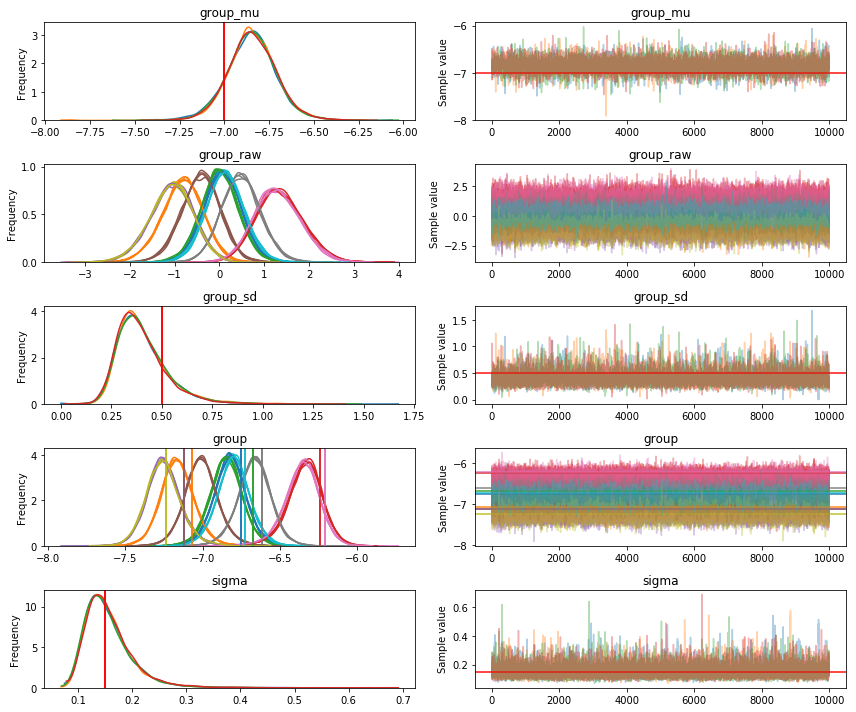

In [4]:
_ = pm.traceplot(trace, lines=truth)

In [13]:
from pymc3.step_methods.hmc import quadpotential
chains = 4
with model:
    cov = np.atleast_1d(pm.trace_cov(trace))
    start = list(np.random.choice(trace, chains))
    potential = quadpotential.QuadPotentialFull(cov)
    step = pm.HamiltonianMC(potential=potential)
    trace_hmc = pm.sample(1000, tune=1000, step=step, start=start)

/home/laoj/Documents/Github/pymc3/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [sigma_log__, group_raw, group_sd_log__, group_mu]
INFO:pymc3:HamiltonianMC: [sigma_log__, group_raw, group_sd_log__, group_mu]
100%|██████████| 2000/2000 [00:01<00:00, 1007.68it/s]
Divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:Divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6468948856816514, but should be close to 0.8. Try to increase the number of tuning steps.
Divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:Divergences after tuning. Increase `target_ac

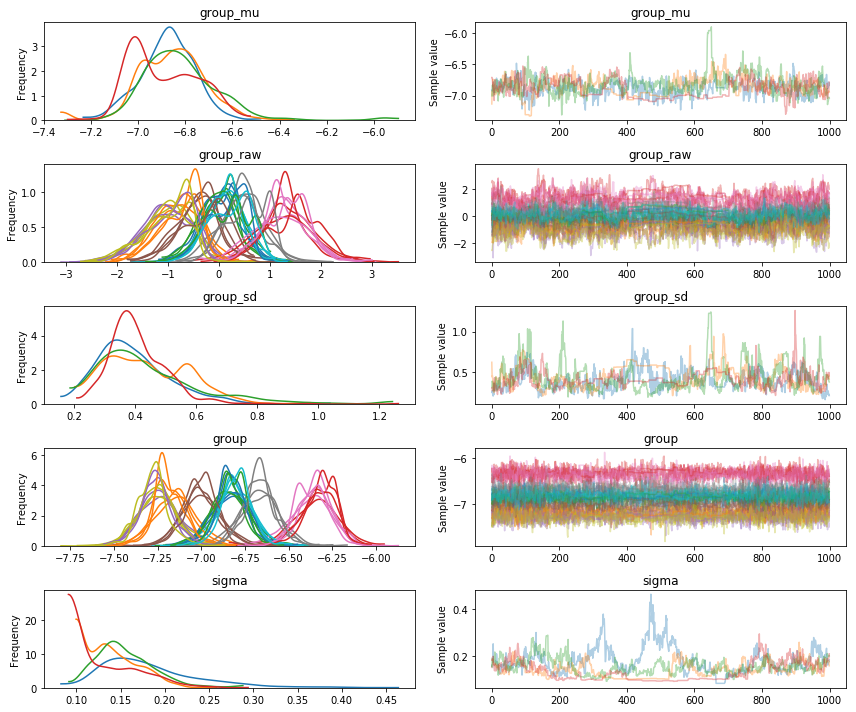

In [14]:
pm.traceplot(trace_hmc);

In [5]:
hyper_vars = [hyper_mu, hyper_sd, hyper_group_sd, hyper_sigma]

In [6]:
replace_hyper = {}
for var in hyper_vars:
    var_ = tt.dscalar(var.name + '__')
    var_.tag.test_value = np.array(0.)
    replace_hyper[var] = var_

In [7]:
replace_hyper.values()

dict_values([hyper_mu__, hyper_sigma__, hyper_group_sd__, hyper_sd__])

In [8]:
for var in hyper_vars:
    print(var.get_value())

0.0
10.0
2.5
2.5


In [9]:
logp_hyper = theano.clone(model.logpt, replace_hyper)
logp_hyper.name = 'logp_hyper__'

In [10]:
dlogp_dhyper = tt.grad(logp_hyper, list(replace_hyper.values()))
vars_hyper = list(replace_hyper.values()) + model.free_RVs
dlogp_dhyper = theano.function(vars_hyper, dlogp_dhyper)

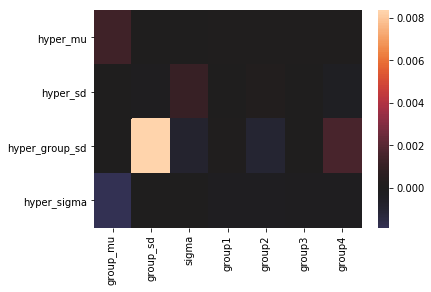

In [26]:
_ = sb.heatmap(sensitivity, center=0)

In [16]:
sensitivity

,group_mu,group_sd,sigma,group1,group2,group3,group4
hyper_mu,0.001375,-0.000013,0.000002,0.000133,0.000129,0.000117,0.000103
hyper_sd,0.000003,-0.000156,0.001108,-0.000006,0.000220,-0.000001,-0.000348
hyper_group_sd,0.000004,0.008363,-0.000870,0.000108,-0.000994,-0.000020,0.001565
hyper_sigma,-0.001886,0.000029,-0.000002,-0.000182,-0.000178,-0.000160,-0.000140


In [39]:
grads_hyper = []

names_hyper = [var.name for var in vars_hyper]

for point in trace.points():
    for var in hyper_vars:
        point[var.name + '__'] = var.get_value() + np.random.randn()
    point = {name: var for name, var in point.items()
             if name in names_hyper}
    grad = dlogp_dhyper(**point)
    grads_hyper.append(grad)

In [40]:
grads_hyper = np.array(grads_hyper)

In [41]:
a = grads_hyper
b = np.c_[trace['group_mu'], trace['group_sd'], trace['sigma'],
          trace['group'][:, 0], trace['group'][:, 1], 
          trace['group'][:, 2], trace['group'][:, 3]]
cov = np.cov(np.c_[a, b].T)[:a.shape[1]][:, a.shape[1]:]
sensitivity = cov / b.std(0)

In [42]:
sensitivity = pd.DataFrame(
    sensitivity,
    columns=['group_mu', 'group_sd', 'sigma', 'group1',
             'group2', 'group3', 'group4'],
    index=[var.name for var in hyper_vars])

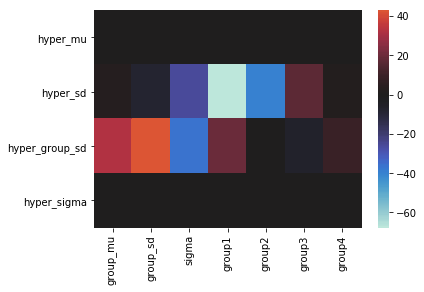

In [43]:
_ = sb.heatmap(sensitivity, center=0)

In [44]:
sensitivity

,group_mu,group_sd,sigma,group1,group2,group3,group4
hyper_mu,0.001283,0.000024,-0.000018,0.000124,0.000166,-0.000058,-0.000096
hyper_sd,2.882758,-7.577961,-25.413019,-67.804092,-39.317644,17.365071,2.008428
hyper_group_sd,32.534159,42.952488,-36.587260,19.846222,-0.500247,-6.287195,9.240794
hyper_sigma,-0.001920,0.000054,-0.000039,-0.000209,-0.000249,-0.000092,-0.000007
